## Setup Cluster

In [1]:
from dask_yarn import YarnCluster
from dask.distributed import Client

/home/hadoop/miniconda/lib/python3.7/site-packages/dask_yarn/core.py:16: FutureWarning: format_bytes is deprecated and will be removed in a future release. Please use dask.utils.format_bytes instead.
  from distributed.utils import (
/home/hadoop/miniconda/lib/python3.7/site-packages/dask_yarn/core.py:16: FutureWarning: parse_timedelta is deprecated and will be removed in a future release. Please use dask.utils.parse_timedelta instead.
  from distributed.utils import (


In [2]:
# Create a cluster where each worker has 4 vCPU core and 8 GiB of memory:
# workers ~ processes, worker_vcores ~ threads
cluster = YarnCluster(environment="/home/hadoop/environment.tar.gz",
                      worker_vcores = 4,
                      worker_memory = "8GiB"
                      )

# Scale cluster out to 4 such workers:
cluster.scale(4)

# Connect to the cluster (before proceeding, you should wait for workers to be registered by the dask scheduler, as below):
client = Client(cluster)

distributed.scheduler - INFO - Clear task state
distributed.scheduler - INFO -   Scheduler at: tcp://172.31.30.183:38265
distributed.scheduler - INFO -   dashboard at:                    :36881
distributed.scheduler - INFO - Receive client connection: Client-8537e09c-5921-11ec-ae59-0a8b222d514f
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://172.31.24.243:36989', name: dask.worker_1, status: undefined, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.24.243:36989
distributed.core - INFO - Starting established connection
distributed.scheduler - INFO - Register worker <WorkerState 'tcp://172.31.20.33:45925', name: dask.worker_0, status: undefined, memory: 0, processing: 0>
distributed.scheduler - INFO - Starting worker compute stream, tcp://172.31.20.33:45925
distributed.core - INFO - Starting established connection


In [3]:
client

Connection method: Cluster object,Cluster type: dask_yarn.YarnCluster
Dashboard: /proxy/36881/status,


In [ ]:
cluster.shutdown()

# Data Exploration

In [4]:
import dask.dataframe as dd
import matplotlib.pyplot as plt
import dask
import pandas as pd
import numpy as np
import boto3

## Import Data

In [5]:
# we tried multiple attempts to enable public access to macs30123-dxu bucket, as well as enabling cross-account access.
# However, none of those worked, as we continued to face "access denied" error.

# df = dd.read_parquet("s3://macs30123-dxu/divvy/divvy_electric.parquet",
#                      engine='fastparquet')
df = dd.read_parquet("s3://macs30123-divvy/divvy_electric.parquet",
                     engine='fastparquet')


In [6]:
df.columns

Index(['index', 'ride_id', 'rideable_type', 'started_at', 'ended_at',
       'start_station_name', 'start_station_id', 'end_station_name',
       'end_station_id', 'start_lat', 'start_lng', 'end_lat', 'end_lng',
       'member_casual', 'year', 'month', 'weekday', 'hour', 'start_zip',
       'end_zip'],
      dtype='object')

In [10]:
# drop rows where start and end zip are NA
df_nonan = df.dropna(subset=['start_zip', 'end_zip'], 
                     how='any')
# generate a variable to denote whether trip crosses zip code
df_zip = df_nonan.assign(cross = lambda x: x.start_zip != x.end_zip)
df_zip = df_zip.assign(count = 1)

In [12]:
df_zip.head()

,index,ride_id,rideable_type,started_at,ended_at,start_station_name,start_station_id,end_station_name,end_station_id,start_lat,...,end_lng,member_casual,year,month,weekday,hour,start_zip,end_zip,cross,count
0,1677,FCC5AF1EE6C90556,electric_bike,2020-07-31 09:02:32,2020-07-31 09:08:02,Southport Ave & Waveland Ave,227,Broadway & Sheridan Rd,256,41.948101,...,-87.650284,member,2020,7,4,9,60613,60613,False,1
1,1678,D250FDFE9547D37D,electric_bike,2020-07-31 10:33:04,2020-07-31 10:36:40,Broadway & Sheridan Rd,256,Halsted St & Roscoe St,299,41.952835,...,-87.648974,member,2020,7,4,10,60613,60657,True,1
2,1679,518886FA68C576E7,electric_bike,2020-07-31 08:24:40,2020-07-31 08:31:08,Broadway & Sheridan Rd,256,Southport Ave & Waveland Ave,227,41.952801,...,-87.664000,member,2020,7,4,8,60613,60613,False,1
3,2309,C567E225898542DD,electric_bike,2020-07-31 13:14:47,2020-07-31 13:21:17,Calumet Ave & 18th St,338,Wabash Ave & 16th St,72,41.857687,...,-87.625791,member,2020,7,4,13,60616,60605,True,1
4,2310,35B9C123ADCD865E,electric_bike,2020-07-31 07:05:09,2020-07-31 07:13:30,Ashland Ave & Chicago Ave,350,Ashland Ave & Augusta Blvd,30,41.895914,...,-87.668511,member,2020,7,4,7,60622,60622,False,1


## Trip destination - Time

In this section, I explore the distribution of cross-zip-code trips vs within-zip-code trips, along different dimensions of time.

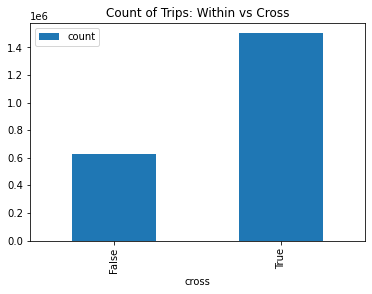

In [32]:
cross_zip_trip = (df_zip[['cross', 'count']].groupby('cross')
                                            .sum())
cross_df = cross_zip_trip.compute()

plt.close()
cross_df.plot(kind='bar', title = 'Count of Trips: Within vs Cross')
plt.savefig('count.png', dpi=200)
plt.show()

Aggregating all trips with known start and end zip code locations, there are about slightly more than twice of cross-zip-code trips than within-zip-code trips.

**Month** 

In [34]:
cross_zip_by_month = (df_zip[['cross', 'count', 'month']].groupby(['cross', 'month'])
                                                         .sum())
cross_month_df = cross_zip_by_month.compute()

cross_month_plot = cross_month_df.reset_index().pivot(index = 'month',
                                                      columns = 'cross',
                                                      values = 'count')
cross_month_plot

cross,False,True
month,,
1,10437,21903
2,3985,9125
3,17200,41914
4,28737,66694
5,52252,121637
6,66626,166774
7,69467,180674
8,88873,221841
9,107383,266559


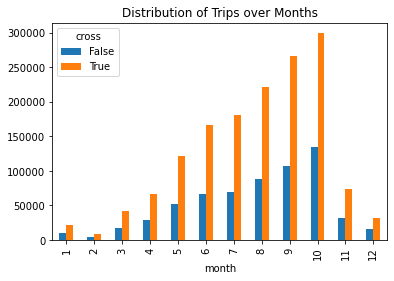

In [35]:
plt.close()
cross_month_plot.plot(kind="bar", title = 'Distribution of Trips over Months')
plt.savefig('month_dist.png', dpi=200)
plt.show()

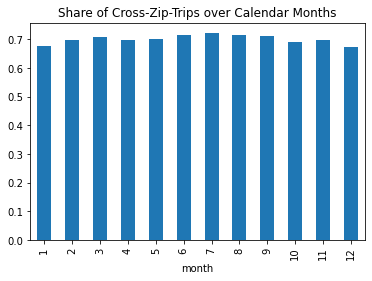

In [36]:
cross_month_plot['ratio'] = cross_month_plot[True] / (cross_month_plot[False] + cross_month_plot[True])
plt.close()
cross_month_plot['ratio'].plot(kind='bar', title = 'Share of Cross-Zip-Trips over Calendar Months')
plt.savefig('month_share.png', dpi=200)
plt.show()

It seems that the ratio is about 0.7 across all months. The variation here is less significant.

**Weekday**

In [37]:
cross_zip_by_weekday = (df_zip[['cross', 'count', 'weekday']].groupby(['cross', 'weekday'])
                                                             .sum())
cross_weekday_df = cross_zip_by_weekday.compute()

cross_weekday_plot = cross_weekday_df.reset_index().pivot(index = 'weekday',
                                                          columns = 'cross',
                                                          values = 'count')
cross_weekday_plot

cross,False,True
weekday,,
0,79649,183771
1,84840,203249
2,86268,210320
3,86998,211967
4,95325,234748
5,103038,250832
6,90041,206824


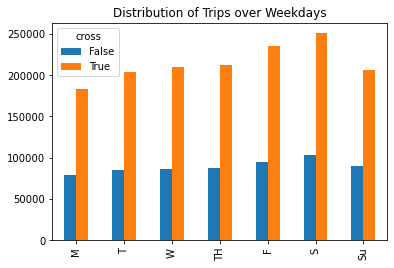

In [38]:
cross_weekday_plot.index = ['M', 'T', 'W', 'TH', 'F', 'S', 'Su']

plt.close()
cross_weekday_plot.plot(kind="bar", title = 'Distribution of Trips over Weekdays')
plt.savefig('weekday_dist.png', dpi=200)
plt.show()

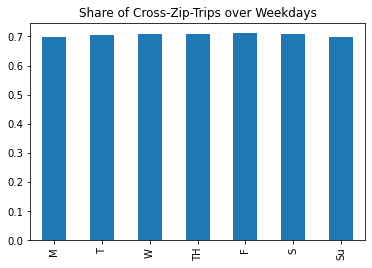

In [39]:
cross_weekday_plot['ratio'] = cross_weekday_plot[True] / (cross_weekday_plot[False] + cross_weekday_plot[True])

plt.close()
cross_weekday_plot['ratio'].plot(kind='bar', title = 'Share of Cross-Zip-Trips over Weekdays')
plt.savefig('weekday_share.png', dpi=200)
plt.show()


Similarly to month, the ratio remains around 0.7 throughout all seven days of the week and shows only small variations.

**Hour**

In [40]:
cross_zip_by_hour = (df_zip[['cross', 'count', 'hour']].groupby(['cross', 'hour'])
                                                       .sum())
cross_hour_df = cross_zip_by_hour.compute()

cross_hour_plot = cross_hour_df.reset_index().pivot(index = 'hour',
                                                    columns = 'cross',
                                                    values = 'count')
cross_hour_plot

cross,False,True
hour,,
0,11613,24570
1,8156,16921
2,5250,10864
3,3081,6486
4,2401,6408
5,3996,13159
6,9192,32453
7,15898,56634
8,21166,66456


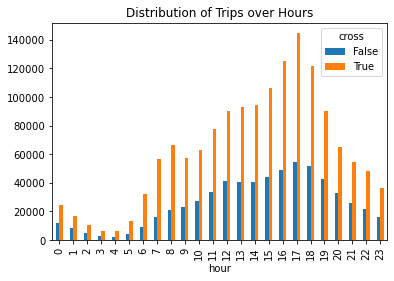

In [41]:
plt.close()
cross_hour_plot.plot(kind="bar", title = 'Distribution of Trips over Hours')
plt.savefig('hour_dist.png', dpi=200)
plt.show()

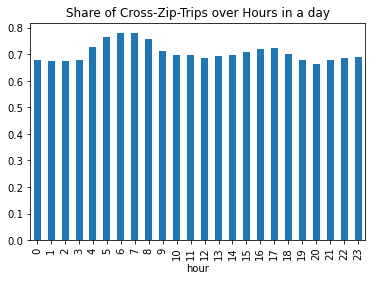

In [42]:
cross_hour_plot['ratio'] = cross_hour_plot[True] / (cross_hour_plot[False] + cross_hour_plot[True])

plt.close()
cross_hour_plot['ratio'].plot(kind='bar', title = 'Share of Cross-Zip-Trips over Hours in a day')
plt.savefig('hour_share.png', dpi=200)
plt.show()


The variation along hours is more interesting. As the graph shows, people tend to make higher shares of cross-zip-code trips in the early morning. This probably makes sense since bike might be the most convenient option for travelling in the morning given that public transportation is not operating frequently at these hours. However, as the distribution graph shows, the sample size in the early morning is extremely small (relatively). If we focus on the time period where people tend to make more trips (10am to 8pm), one interesting observation is that during the time period where people travel most (4-5pm), the cross-zip-code trip share is slightly higher (a small peak) than other hours. This coincides with the rush hour, and implies that people do use bike as an important transportation method to travel at medium distance. THis could be simply taking bike to the end destination, or to the closest train/bus station, from which they will travel for longer distance in another transportation method.

## Trip destination - Time

In this section, I explore the distribution of cross-zip-code trips vs within-zip-code trips, along the dimension of membership (whether the rider is a subscriber of divvy bike, or a causal user).

In [43]:
cross_zip_by_member = (df_zip[['cross', 'count', 'member_casual']].groupby(['cross', 'member_casual'])
                                                            .sum())
cross_member_df = cross_zip_by_member.compute()

cross_member_plot = cross_member_df.reset_index().pivot(index = 'member_casual',
                                                        columns = 'cross',
                                                        values = 'count')
cross_member_plot

cross,False,True
member_casual,,
casual,296716,712314
member,329443,789397


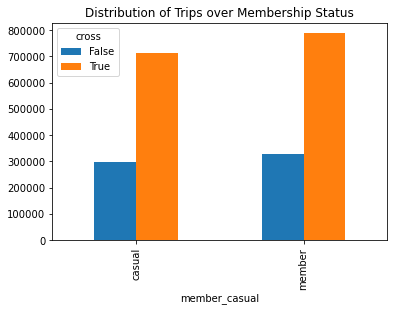

In [44]:
plt.close()
cross_member_plot.plot(kind="bar", title = 'Distribution of Trips over Membership Status')
plt.savefig('member_dist.png', dpi=200)
plt.show()

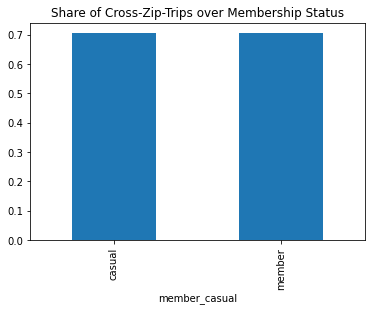

In [45]:
cross_member_plot['ratio'] = cross_member_plot[True] / (cross_member_plot[False] + cross_member_plot[True])

plt.close()
cross_member_plot['ratio'].plot(kind='bar', title = 'Share of Cross-Zip-Trips over Membership Status')
plt.savefig('member_share.png', dpi=200)
plt.show()


It seems that member and causal riders have similar share in terms of cross-zip-code trips. Interestingly, they also have similar number of rides in total. This contradicts with our expectation that there would be more member rides (an observation derived from docked bikes). It might be that electric bikes are truly convenient such that even causal riders use them a lot.

## Trip destination - Start Point

In this section, I explore the distribution of cross-zip-code trips vs within-zip-code trips, along the dimension of where the trip starts. This is to see if trips start from certain place are more likely to travel across zip codes.

In [46]:
cross_zip_by_station = (df_zip[['cross', 'count', 'start_station_id']].groupby(['cross', 'start_station_id'])
                                                                      .sum())
cross_station_df = cross_zip_by_station.compute()

cross_station_plot = cross_station_df.reset_index().pivot(index = 'start_station_id',
                                                         columns = 'cross',
                                                         values = 'count')
cross_station_plot

cross,False,True
start_station_id,,
100,75.0,1039.0
101,84.0,108.0
102,26.0,69.0
103,10.0,87.0
106,175.0,788.0
...,...,...
TA1309000066,1407.0,2496.0
TA1309000067,153.0,189.0
WL-008,401.0,1888.0


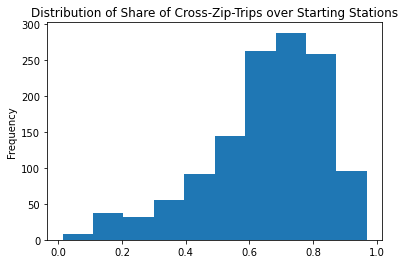

In [47]:
cross_station_plot['ratio'] = cross_station_plot[True] / (cross_station_plot[False] + cross_station_plot[True])

plt.close()
cross_station_plot['ratio'].plot(kind='hist', title = 'Distribution of Share of Cross-Zip-Trips over Starting Stations')
plt.savefig('station_hist.png', dpi=200)
plt.show()


As expected, share of around 0.7 has the highest frequency, which is consistent with information seen in previous graphs. Interestingly, there are also considerable number of stations where the share of cross-zip-code are high (close to 1). The starting station could be an important identifier in predicting whether a biking trip crosses zip-code.


In [48]:
cross_zip_by_szip = (df_zip[['cross', 'count', 'start_zip']].groupby(['cross', 'start_zip'])
                                                            .sum())
cross_szip_df = cross_zip_by_szip.compute()

cross_szip_plot = cross_szip_df.reset_index().pivot(index = 'start_zip',
                                                    columns = 'cross',
                                                    values = 'count')
cross_szip_plot

cross,False,True
start_zip,,
60601,5406,40122
60602,1405,19489
60603,6334,34906
60604,709,12961
60605,21153,56850
60606,2567,31300
60607,20679,72983
60608,10847,22679
60609,4514,7567


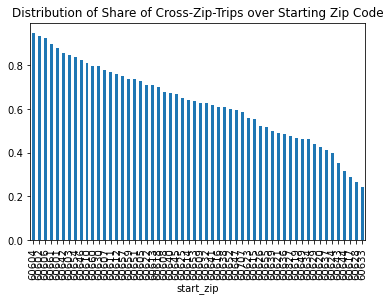

In [49]:
cross_szip_plot['ratio'] = cross_szip_plot[True] / (cross_szip_plot[False] + cross_szip_plot[True])

plt.close()
cross_szip_plot['ratio'].sort_values(ascending=False).plot(kind='bar', title = 'Distribution of Share of Cross-Zip-Trips over Starting Zip Code')
plt.savefig('zip_dist.png', dpi=200)
plt.show()

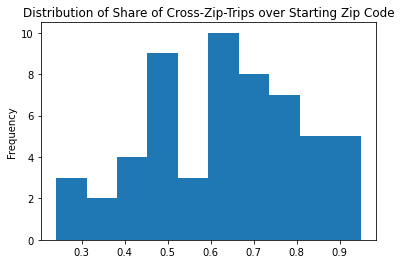

In [50]:
plt.close()
cross_szip_plot['ratio'].plot(kind='hist', title = 'Distribution of Share of Cross-Zip-Trips over Starting Zip Code')
plt.savefig('zip_hist.png', dpi=200)
plt.show()


The distribution by starting zip code is also very intersting. The variation is signficant across starting zip code. There are indeed a relatively large number of starting zip code where the trip eventually becomes cross-zip-code. This could also be an interesting feature for prediction.